In [19]:
from qiskit import QuantumCircuit, transpile, Aer
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.providers.aer import QasmSimulator
from qiskit import Aer, execute
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector
from qiskit.circuit.library import PauliFeatureMap, ZFeatureMap, ZZFeatureMap
from qiskit.circuit.library import TwoLocal, NLocal, RealAmplitudes, EfficientSU2
from qiskit.circuit.library import HGate, RXGate, RYGate, RZGate, CXGate, CRXGate, CRZGate
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error
from qiskit.utils.mitigation import complete_meas_cal, CompleteMeasFitter

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from mlxtend.plotting import plot_decision_regions

In [20]:
import numpy as np
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [21]:
iris = datasets.load_iris()

In [22]:
iris_df = pd.DataFrame(iris.data, columns = iris.feature_names)
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [23]:
sepal_length = iris['data'][:, 0]
sepal_width = iris['data'][:, 1]
petal_length = iris['data'][:, 2]
petal_width = iris['data'][:, 3]

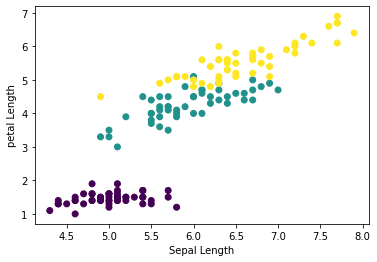

In [24]:
target = iris['target']
plt.scatter(sepal_length, petal_length, c = target)
plt.xlabel('Sepal Length')
plt.ylabel('petal Length')
plt.show()

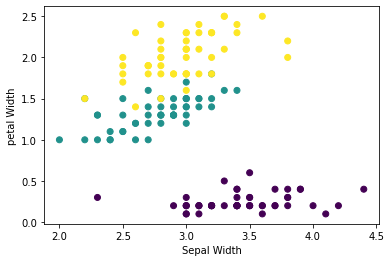

In [25]:
target = iris['target']
plt.scatter(sepal_width, petal_width, c = target)
plt.xlabel('Sepal Width')
plt.ylabel('petal Width')
plt.show()

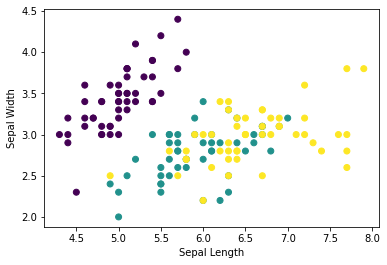

In [26]:
target = iris['target']
plt.scatter(sepal_length, sepal_width, c = target)
plt.xlabel('Sepal Length')
plt.ylabel('Sepal Width')
plt.show()

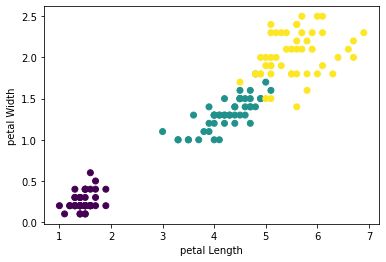

In [27]:
target = iris['target']
plt.scatter(petal_length, petal_width, c = target)
plt.xlabel('petal Length')
plt.ylabel('petal Width')
plt.show()

In [28]:
X = np.column_stack((sepal_length, sepal_width, petal_length, petal_width))
y = iris.target

x_train, x_test, y_train, y_test = train_test_split(X,y, test_size = 0.4, random_state=25)

In [29]:
clf = svm.SVC(kernel = 'linear', C = 1)
clf.fit(x_train, y_train)

SVC(C=1, kernel='linear')

In [30]:
clf.score(x_test, y_test)

0.9666666666666667

In [31]:
clf.score(x_train, y_train)

0.9888888888888889

In [32]:
sample_train, sample_test, label_train, label_test = train_test_split(X,y, test_size=0.4, random_state=25)

print(sample_train[0], label_train[0])
print(sample_test[0], label_test[0])

[6.2 2.8 4.8 1.8] 2
[5.2 3.4 1.4 0.2] 0


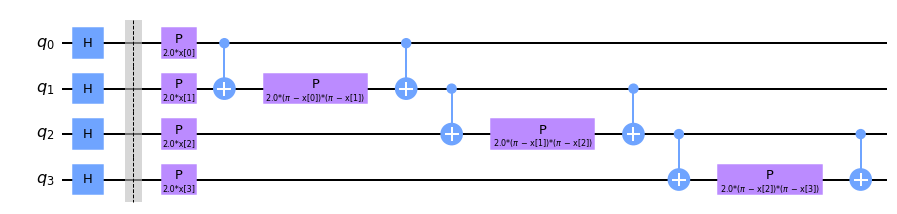

In [33]:
# 4 features, depth 4
map_zz = ZZFeatureMap(feature_dimension = 4, reps = 1, entanglement = 'linear', insert_barriers = True)
map_zz.decompose().draw('mpl')

In [34]:
a = len(sample_train)
print(a)

90


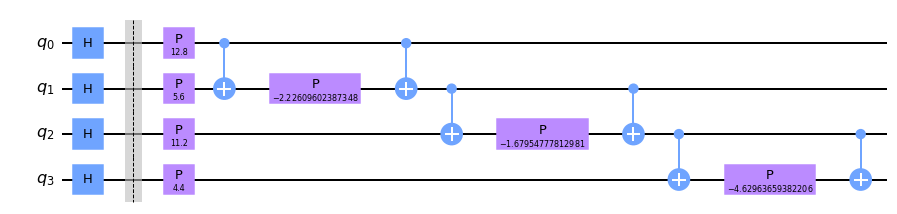

In [35]:
encode_map = map_zz
for i in range (0,a):
    encode_circuit = encode_map.bind_parameters(sample_train[i])
    i = i+1
encode_circuit.decompose().draw(output='mpl')


In [36]:
zz_kernel = QuantumKernel(feature_map = map_zz, quantum_instance = Aer.get_backend('statevector_simulator'))

In [37]:
print(sample_train[0])
print(sample_train[1])

[6.2 2.8 4.8 1.8]
[6.7 2.5 5.8 1.8]


In [38]:
def get_noise(pm,pg):
    error_meas = pauli_error([('X',pm), ('I', 1 - pm)])
    error_gate1 = depolarizing_error(pg,1)
    error_gate2 = error_gate1.tensor(error_gate1)
    
    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_meas, "measure") # measurement error is applied to measurements
    noise_model.add_all_qubit_quantum_error(error_gate1, ["h"]) # single qubit gate error is applied to H gates
    noise_model.add_all_qubit_quantum_error(error_gate1, ["p"]) # single qubit gate error is applied to P gates
    noise_model.add_all_qubit_quantum_error(error_gate2, ["cx"]) # two qubit gate error is applied to CX gates
    
    return noise_model

In [39]:
noise_model = get_noise(0.1,0.1)

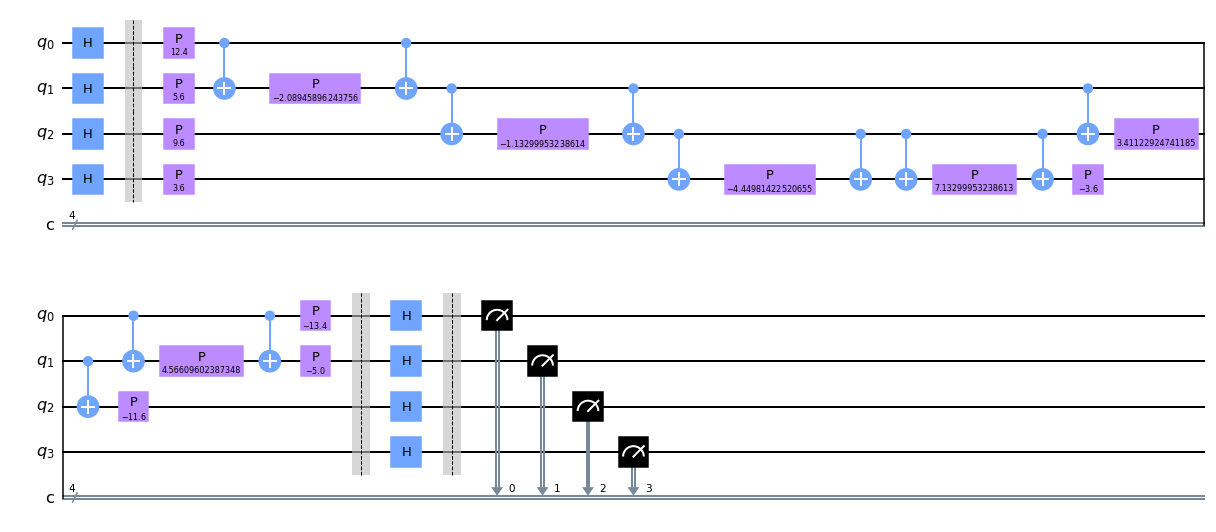

In [40]:
zz_circuit = zz_kernel.construct_circuit(sample_train[0], sample_train[1])
zz_circuit.decompose().decompose().draw(output='mpl')

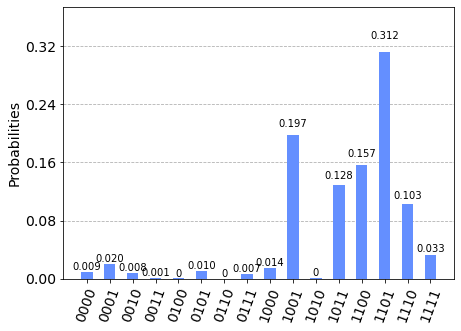

In [41]:
#Without Noise
sim = Aer.get_backend('statevector_simulator')
result = execute(zz_circuit, backend= sim, shots=8192, seed_simulator=1024, seed_transpiler=1024).result()
counts = result.get_counts(zz_circuit)
plot_histogram(counts)

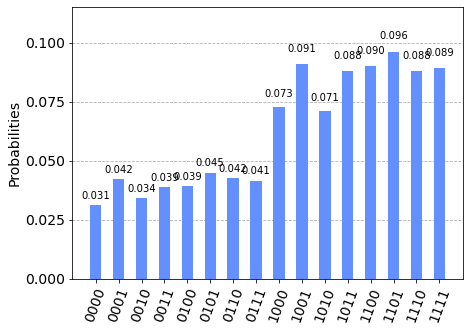

In [42]:
#With Noise
sim = Aer.get_backend('statevector_simulator')
result_n = execute(zz_circuit, backend = sim, shots=8192, seed_simulator=1024, seed_transpiler=1024, noise_model=noise_model).result()
counts_n = result_n.get_counts(zz_circuit)
plot_histogram(counts_n)

In [43]:
#Error mitigation
meas_calibs, state_labels = complete_meas_cal(qr=4, circlabel='mcal')

sim = Aer.get_backend('statevector_simulator')
cal_results = execute(meas_calibs, backend = sim, shots=8192, seed_simulator=1024, seed_transpiler=1024, noise_model=noise_model).result()

meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')

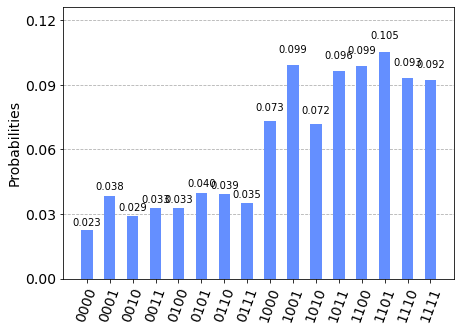

In [44]:
meas_filter = meas_fitter.filter
mitigated_results = meas_filter.apply(result_n)
mitigated_counts = mitigated_results.get_counts(0)
plot_histogram(mitigated_counts)

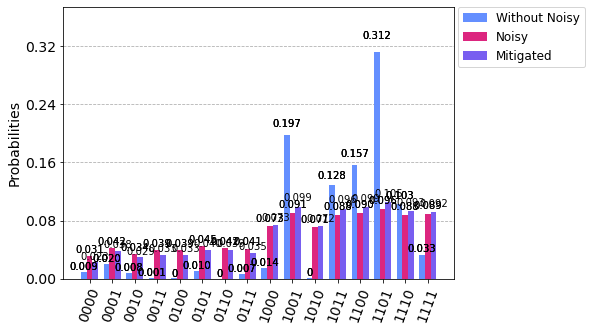

In [45]:
plot_histogram([counts, counts_n, mitigated_counts], legend=['Without Noisy','Noisy', 'Mitigated'])

In [46]:
counts['0000']/sum(counts.values())

0.009033203125

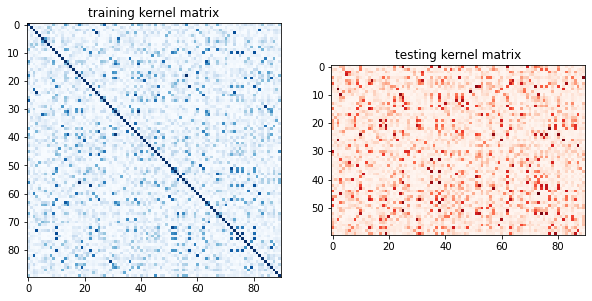

In [47]:
matrix_train = zz_kernel.evaluate(x_vec = sample_train)
matrix_test = zz_kernel.evaluate(x_vec = sample_test, y_vec = sample_train)

fig, axs = plt.subplots(1, 2, figsize = (10, 5))
axs[0].imshow(np.asmatrix(matrix_train),
              interpolation ='nearest', origin ='upper', cmap ='Blues')
axs[0].set_title("training kernel matrix")
axs[1].imshow(np.asmatrix(matrix_test),
              interpolation ='nearest', origin ='upper', cmap ='Reds')
axs[1].set_title("testing kernel matrix")
plt.show()

In [48]:
zzcb_svc = SVC(kernel=zz_kernel.evaluate)
zzcb_svc.fit(sample_train, label_train)
zzcb_score = zzcb_svc.score(sample_test, label_test)

print(f'Callable kernel classification test score: {zzcb_score}')

Callable kernel classification test score: 0.9
